# Modelling and Evaluation

## Objectives

* Answer business requirement  - the stakeholder wishes to predict whether a lemon is of good or poor quality from a photograph.

## Inputs

* lemon-quality-dataset/lemon_dataset/train
* lemon-quality-dataset/lemon_dataset/validation
* lemon-quality-dataset/lemon_dataset/test
* Image shape embeddings

## Outputs

* Class indices for datasets
* TensorFlow machine learning model
* Hyperparameter optimisation pipeline
* Model trained on best hyperparameters
* Learning curve plot to evaluate model performance
* Model evaluation
* Confusion Matrix for Test Set




---

## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Change working directory

* We are assuming you will store the notebooks in a sub folder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/lemon-quality-control/jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/lemon-quality-control'

### Set Input Directories

In [5]:
my_data_dir = 'inputs/lemon-quality-dataset/lemon_dataset'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['bad_quality', 'good_quality']


Set image shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(300, 300, 3)

## Number of images in train, validation, and test sets

* train - bad_quality: 665 images
* train - good_quality: 787 images
* validation - bad_quality: 95 images
* validation - good_quality: 112 images
* test - bad_quality: 191 images
* test - good_quality: 226 images




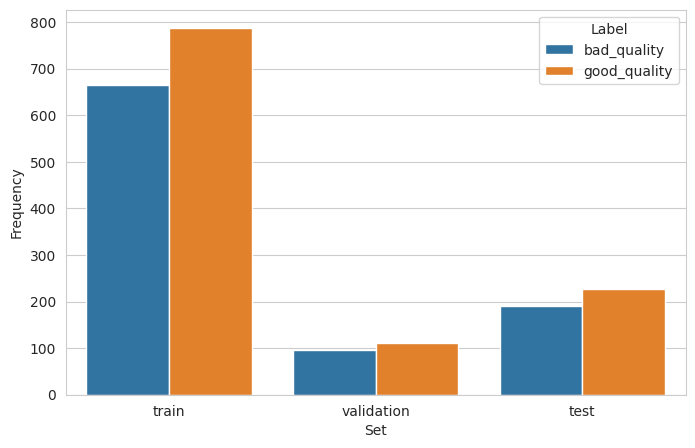

In [10]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## Image Data Augmentation

### Image Data Generator

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Initialise image data generator and define parameters

In [10]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Augment training image dataset

In [11]:
batch_size = 20 
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 1452 images belonging to 2 classes.


{'bad_quality': 0, 'good_quality': 1}

Augment validation image dataset

In [12]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 207 images belonging to 2 classes.


{'bad_quality': 0, 'good_quality': 1}

Augment test image dataset

In [13]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 417 images belonging to 2 classes.


{'bad_quality': 0, 'good_quality': 1}

---

## Plot Augmented training images

(20, 300, 300, 3)


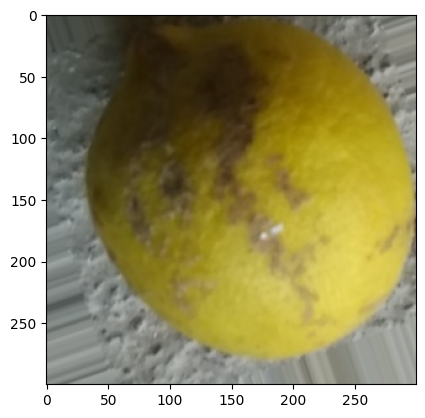

(20, 300, 300, 3)


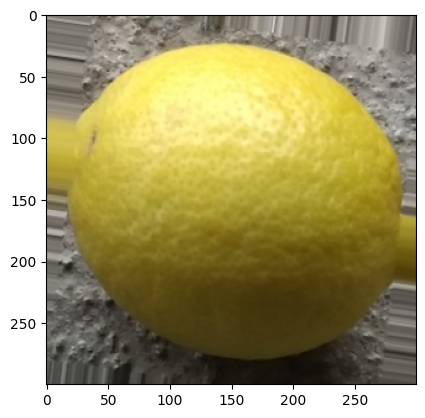

(20, 300, 300, 3)


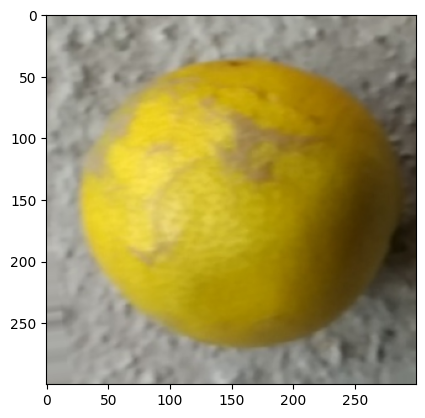

In [14]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Plot augmented validation images

(20, 300, 300, 3)


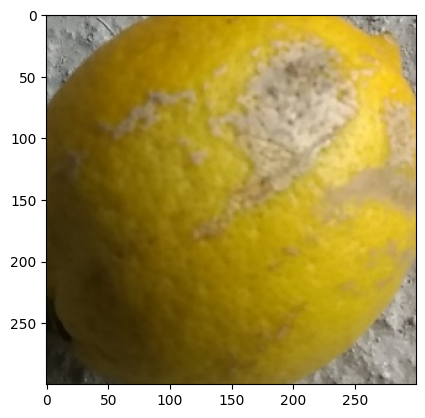

(20, 300, 300, 3)


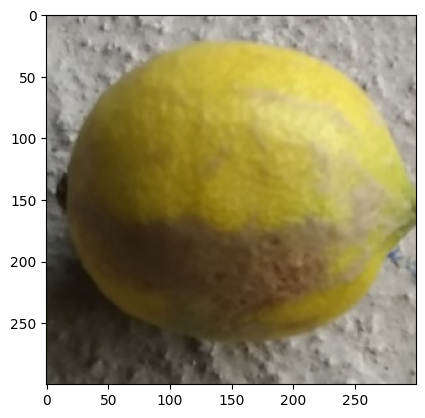

(20, 300, 300, 3)


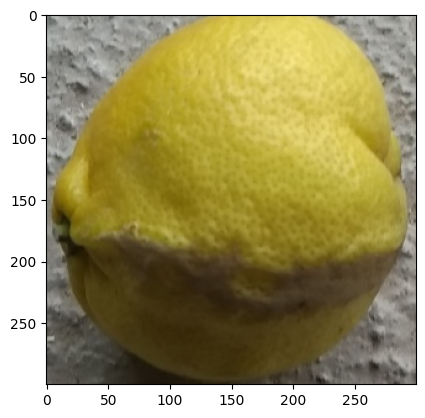

In [16]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Plot augmented test set images

(20, 300, 300, 3)


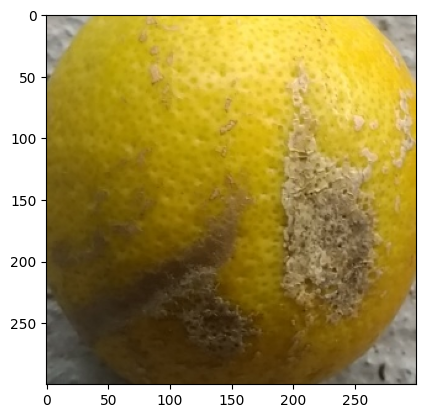

(20, 300, 300, 3)


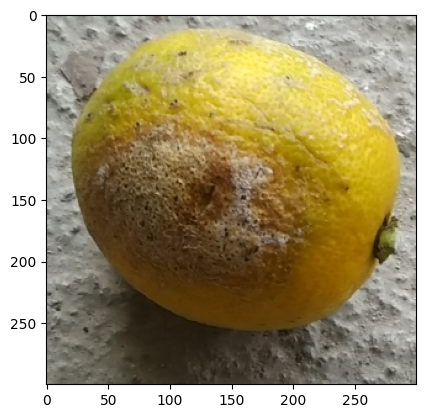

(20, 300, 300, 3)


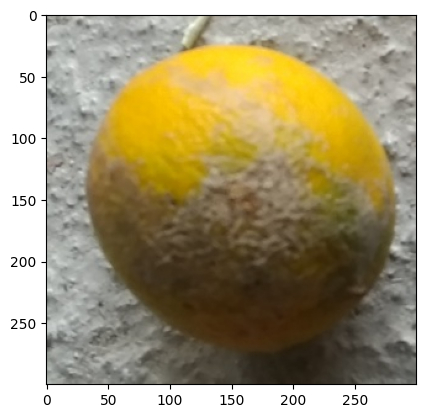

In [17]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Save class indices

In [21]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

Import layers for model creation and tuner for hyperparameter optimisation

In [15]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D



Define hypermodel for hypertuning

In [17]:
def model_builder(hp):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    hp_units = hp.Int('units', min_value=32, max_value=480, step=64)
    model.add(Dense(units=hp_units, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

Perform hyperparameter tuning - hyperband chosen as tuner for processing speed

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=file_path,
                     project_name='hypertuning'
                     )

Import early stopping

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

Perform tuner search

In [23]:
tuner.search(train_set, 
epochs=25, 
steps_per_epoch = len(train_set.classes) // batch_size, 
validation_data=validation_set, 
callbacks=[early_stop], 
verbose=2)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 21 Complete [00h 07m 25s]
val_accuracy: 0.9420289993286133

Best val_accuracy So Far: 0.9710144996643066
Total elapsed time: 01h 56m 47s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 352 and the optimal learning rate for the optimizer
is 0.001.



Create model

In [16]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [17]:
create_tf_model().summary()

2022-10-19 14:27:30.099285: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

In [19]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2022-10-19 14:28:20.211851: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
72/72 [==============================] - 92s 1s/step - loss: 0.6287 - accuracy: 0.6969 - val_loss: 0.3928 - val_accuracy: 0.8164
Epoch 2/25
72/72 [==============================] - 71s 988ms/step - loss: 0.3264 - accuracy: 0.8610 - val_loss: 0.4305 - val_accuracy: 0.8019
Epoch 3/25
72/72 [==============================] - 118s 2s/step - loss: 0.4239 - accuracy: 0.8338 - val_loss: 0.3962 - val_accuracy: 0.8068
Epoch 4/25
72/72 [==============================] - 120s 2s/step - loss: 0.3347 - accuracy: 0.8659 - val_loss: 0.1245 - val_accuracy: 0.9469
Epoch 5/25
72/72 [==============================] - 110s 2s/step - loss: 0.2049 - accuracy: 0.9232 - val_loss: 0.1013 - val_accuracy: 0.9614
Epoch 6/25
72/72 [==============================] - 126s 2s/step - loss: 0.1552 - accuracy: 0.9448 - val_loss: 0.1480 - val_accuracy: 0.9372
Epoch 7/25
72/72 [==============================] - 148s 2s/step - loss: 0.2436 - accuracy: 0.9085 - val_loss: 0.0923 - val_accuracy: 0.9420
Epoch 8/25
7

Save model

In [20]:
model.save('outputs/v1/lemon_quality_model.h5')

### Model Performance

Model learning curve

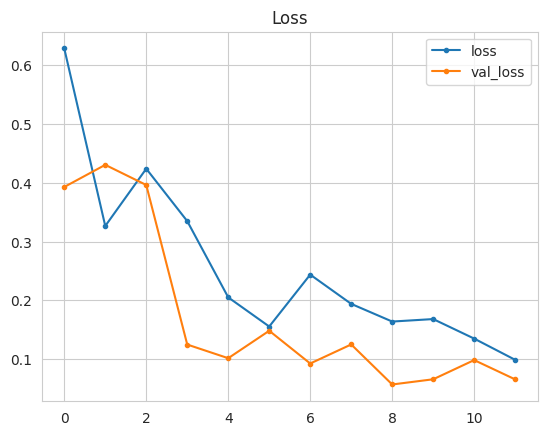

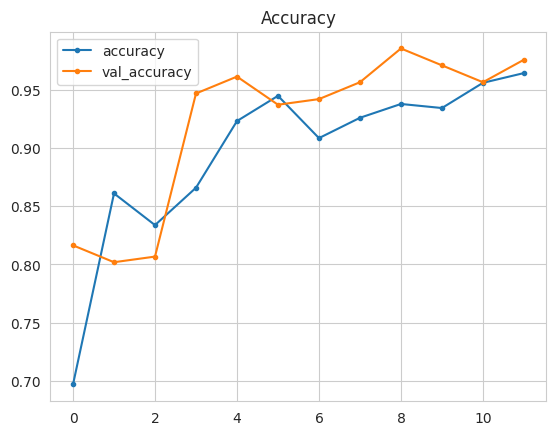

In [21]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

Load saved model

In [22]:
from keras.models import load_model
model = load_model('outputs/v1/lemon_quality_model.h5')

Evaluate saved model on test set

In [23]:
evaluation = model.evaluate(test_set)

21/21 [==============================] - 14s 685ms/step - loss: 0.0716 - accuracy: 0.9568


Save evaluation pickle

In [24]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

Load random image

Image shape: (300, 300), Image mode: RGB


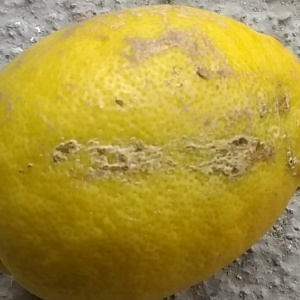

In [41]:
from tensorflow.keras.preprocessing import image

pointer = 49 
label = labels[0] # select bad or good quality

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [42]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 300, 300, 3)


Predict class probabilities

In [43]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999985755615626
bad_quality


## Confusion matrix

## Push generated files to GitHub repo

In [1]:
!cat .gitignore


cat: .gitignore: No such file or directory


In [2]:
!git status

On branch main
Your branch is ahead of 'origin/main' by 2 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../.gitignore
	modified:   ../README.md
	modified:   Modelling and Evaluation.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
! git add .

In [ ]:
! git commit -m 'Train model, add new plots to display model performance and learning curve, evaluate model on live data'

In [ ]:
!git push
